In [335]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Flatten, Dropout, Dense
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model

In [336]:
class SGAN(keras.Model):
  def __init__(self):
    super(SGAN, self).__init__()
    self.latent_dims = 128
    self.img_shape = (28, 28, 1)
    self.n_classes = 10
    self.discriminator = self.build_disc()
    self.generator = self.build_gen()

  def compile(self, d_optimizer, g_optimizer, unsup_loss_fn, sup_loss_fn):
    super(SGAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.unsup_loss_fn = unsup_loss_fn
    self.sup_loss_fn = sup_loss_fn  # sparse categorical crossentropy

  def train_step(self, data):
    real_image, labels = data
    batch_size = tf.shape(real_image)[0]
    noise = tf.random.normal([batch_size, self.latent_dims])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_image = self.generator(noise, training=True)

      real_sup_output, real_unsup_output = self.discriminator(real_image, training=True)
      fake_sup_output, fake_unsup_output = self.discriminator(generated_image, training=True)

      d_loss = tf.reduce_mean(self.sup_loss_fn(labels["sup_label"], real_sup_output)) + tf.reduce_mean(self.unsup_loss_fn(labels["unsup_label"], real_unsup_output))
      d_loss = d_loss + tf.reduce_mean(self.unsup_loss_fn(tf.zeros_like(fake_unsup_output), fake_unsup_output))
      g_loss = tf.reduce_mean(self.unsup_loss_fn(tf.ones_like(fake_unsup_output), fake_unsup_output))
    
    gradients_of_discriminator = disc_tape.gradient(d_loss, self.discriminator.trainable_weights)
    gradients_of_generator = gen_tape.gradient(g_loss, self.generator.trainable_weights)

    self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_weights))
    self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_weights))

    return {"d_loss": d_loss, "g_loss": g_loss}

  def plot_images(self):
    seed = tf.random.normal([16, 128])
    predictions = self.generator(seed, training=False)
    print(type(predictions))

    fig, axs = plt.subplots(4, 4, figsize=(4,4))
    cnt = 0
    for i in range(4):
      for j in range(4):
        axs[i, j].imshow(predictions[cnt, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        cnt += 1
        plt.axis("off")
    plt.show()

  def build_disc(self):
    image = Input(shape=self.img_shape)
    x = Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding="same")(image)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Flatten()(x)

    x = Dropout(0.5)(x)

    unsupervised_output = Dense(1, activation="sigmoid")(x)

    supervised_output = Dense(self.n_classes+1, activation="softmax")(x)
    model = Model(image, [supervised_output, unsupervised_output])

    return model

  def build_gen(self):
    z = Input(shape=(self.latent_dims,))
    x = Dense(7*7*128)(z)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((7, 7, 128))(x)
    x = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    output = Conv2D(filters=1, kernel_size=(7,7), padding="same", activation="tanh")(x)
    generator = Model(z, output)
    return generator


In [337]:
import numpy as np
from tensorflow.keras.utils import to_categorical
sgan = SGAN()

(X_train, y_train), (_, _) = keras.datasets.mnist.load_data()
X_train = (X_train.astype("float32") - 127.5) / 127.5
X_train = np.reshape(X_train, (-1, 28, 28, 1))
# y_train = to_categorical(y_train, 10)

In [338]:
def supervised_data(X, y):
  index = list()
  for i in range(10):
    for ix in range(len(X)):
      if y[ix]==i:
        index.append(ix)
        if len(index)%10 == 0 and len(index) != 0:
          break
  return np.asarray(index)
index = supervised_data(X_train, y_train)
index

array([  1,  21,  34,  37,  51,  56,  63,  68,  69,  75,   3,   6,   8,
        14,  23,  24,  40,  59,  67,  70,   5,  16,  25,  28,  76,  82,
       109, 117, 120, 122,   7,  10,  12,  27,  30,  44,  49,  50,  74,
        86,   2,   9,  20,  26,  53,  58,  60,  61,  64,  89,   0,  11,
        35,  47,  65, 100, 132, 138, 145, 173,  13,  18,  32,  36,  39,
        62,  66,  73,  83,  90,  15,  29,  38,  42,  52,  71,  79,  84,
        91,  96,  17,  31,  41,  46,  55,  85,  94,  97, 125, 137,   4,
        19,  22,  33,  43,  45,  48,  54,  57,  80])

In [339]:
y_train[index]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], dtype=uint8)

In [340]:
all_index = np.arange(60000)
remain_index = np.setdiff1d(all_index, index)
remain_index.shape

(59900,)

In [341]:
X_sup = X_train[index]
y_sup = y_train[index]
X_sup.shape

(100, 28, 28, 1)

In [342]:
X_unsup = X_train[remain_index]
y_unsup = np.ones(60000)
y_unsup.shape

(60000,)

In [343]:
y_unsup

array([1., 1., 1., ..., 1., 1., 1.])

In [344]:
X = np.concatenate((X_sup, X_unsup), axis=0)
X.shape

(60000, 28, 28, 1)

In [345]:
k = np.full(59900, 10)
k.shape
y_sup = np.concatenate((y_sup, k), axis=0)
y_sup.shape

(60000,)

In [346]:
data = tf.data.Dataset.from_tensor_slices((
  X,{
    "sup_label": y_sup,
    "unsup_label": y_unsup
}))
data = data.shuffle(buffer_size=1024).batch(64)

In [347]:
feature, labels = next(iter(data))

In [348]:
labels

{'sup_label': <tf.Tensor: shape=(64,), dtype=int64, numpy=
 array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10,  4, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  4, 10, 10])>,
 'unsup_label': <tf.Tensor: shape=(64,), dtype=float64, numpy=
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])>}

In [349]:
sgan.compile(
  d_optimizer=keras.optimizers.Adam(learning_rate=3e-4),
  g_optimizer=keras.optimizers.Adam(learning_rate=3e-4),
  unsup_loss_fn=keras.losses.BinaryCrossentropy(from_logits=False),
  sup_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=False)
)

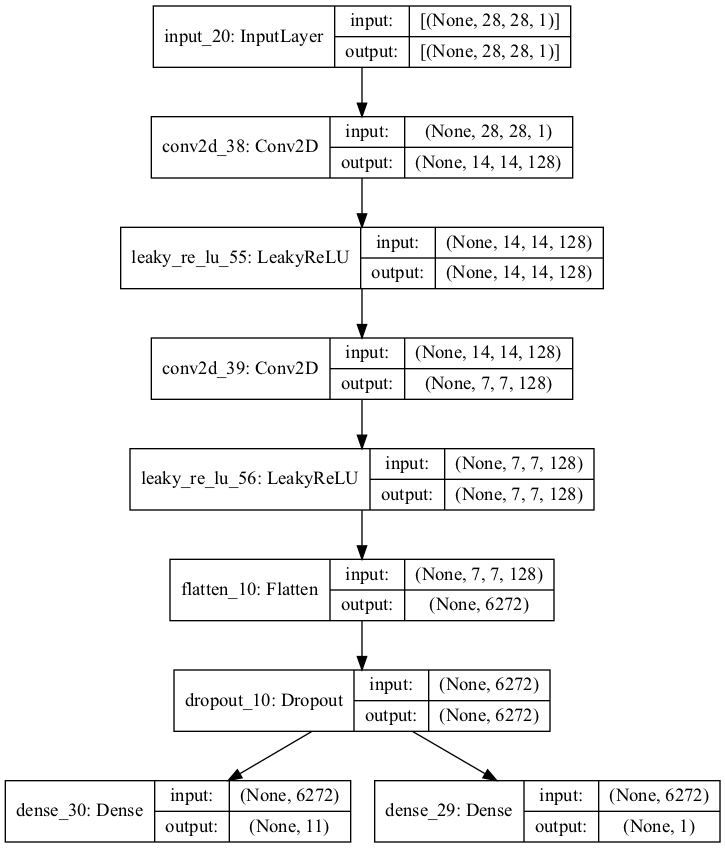

In [350]:
tf.keras.utils.plot_model(sgan.discriminator, to_file='disc.png', show_shapes=True, show_layer_names=True)

In [351]:
sgan.discriminator.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 14, 14, 128)  1280        input_20[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_55 (LeakyReLU)      (None, 14, 14, 128)  0           conv2d_38[0][0]                  
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 7, 7, 128)    147584      leaky_re_lu_55[0][0]             
___________________________________________________________________________________________

In [352]:
sgan.generator.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_31 (Dense)             (None, 6272)              809088    
_________________________________________________________________
leaky_re_lu_57 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_58 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 28, 28, 128)       262

In [353]:
sgan.fit(data, epochs=20)

Epoch 1/20


2022-01-14 16:58:56.703789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 99s 105ms/step - d_loss: 0.0908 - g_loss: 6.8394
Epoch 2/20
938/938 [==============================] - 98s 105ms/step - d_loss: 0.0160 - g_loss: 8.5790
Epoch 3/20
938/938 [==============================] - 98s 105ms/step - d_loss: 0.0135 - g_loss: 9.1687
Epoch 4/20
938/938 [==============================] - 98s 105ms/step - d_loss: 0.0124 - g_loss: 9.5811
Epoch 5/20
938/938 [==============================] - 98s 105ms/step - d_loss: 0.0122 - g_loss: 10.0990
Epoch 6/20
938/938 [==============================] - 98s 105ms/step - d_loss: 0.0121 - g_loss: 10.1788
Epoch 7/20
938/938 [==============================] - 98s 105ms/step - d_loss: 0.0123 - g_loss: 11.0344
Epoch 8/20
938/938 [==============================] - 98s 105ms/step - d_loss: 0.0097 - g_loss: 11.6892
Epoch 9/20
938/938 [==============================] - 98s 105ms/step - d_loss: 0.3860 - g_loss: 9.5813
Epoch 10/20
938/938 [==============================] - 98s 105ms/step - d_loss: 

<class 'tensorflow.python.framework.ops.EagerTensor'>


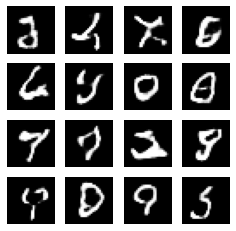

In [354]:
sgan.plot_images()